# **TASK 1: Exploratory Sales Analysis**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")


In [3]:
df = pd.read_csv("D:/sql datasets/store-sales-time-series-forecasting/train.csv")
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [5]:
df.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [8]:
mean_sales = df['sales'].mean()
median_sales = df['sales'].median()
mode_sales = df['sales'].mode()[0]

print("Mean Sales:", mean_sales)
print("Median Sales:", median_sales)
print("Mode Sales:", mode_sales)


Mean Sales: 357.77574911261877
Median Sales: 11.0
Mode Sales: 0.0


In [9]:
daily_sales = df.groupby('date')['sales'].sum().reset_index()

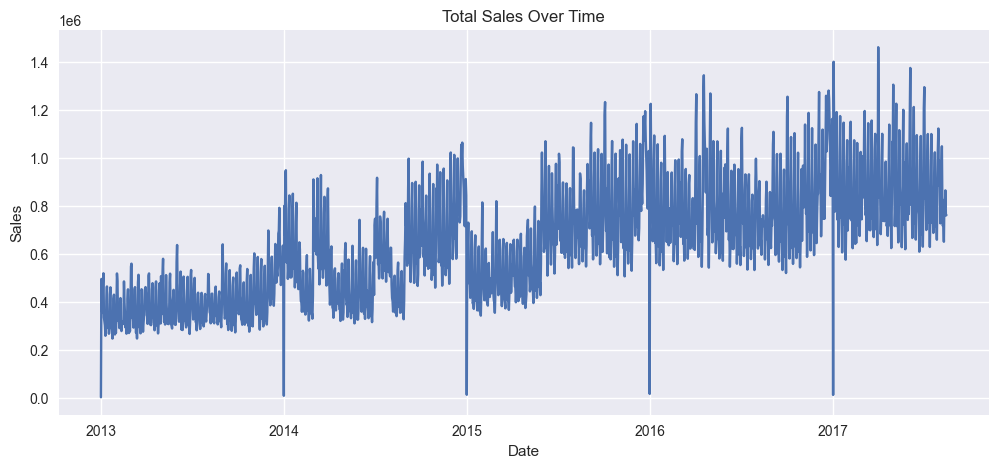

In [10]:
plt.figure(figsize=(12,5))
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

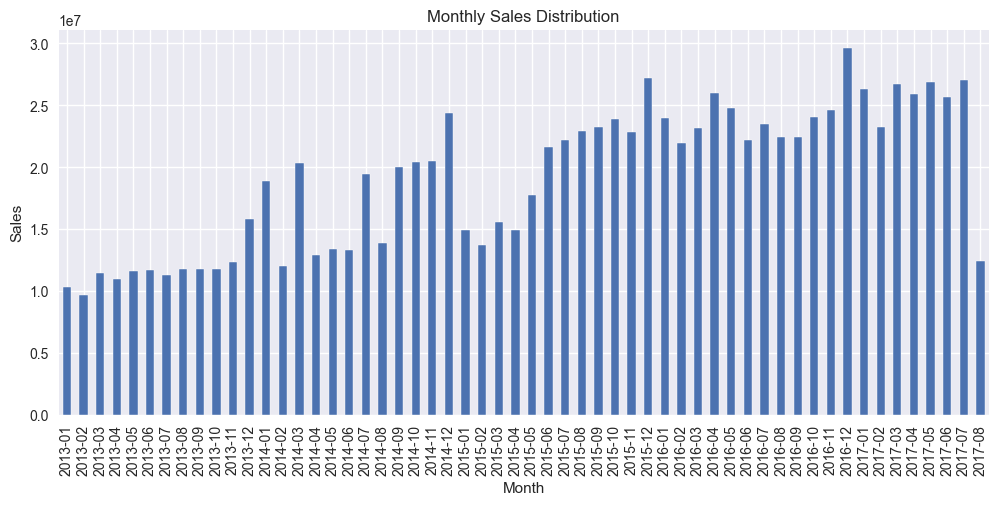

In [11]:
daily_sales['month'] = daily_sales['date'].dt.to_period("M")

monthly_sales = daily_sales.groupby('month')['sales'].sum()

monthly_sales.plot(kind='bar', figsize=(12,5))
plt.title("Monthly Sales Distribution")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()


# **TASK 2: Simple Sales Forecast with Moving Average**

In [12]:
daily_sales['MA_7'] = daily_sales['sales'].rolling(window=7).mean()

In [13]:
daily_sales['MA_30'] = daily_sales['sales'].rolling(window=30).mean()

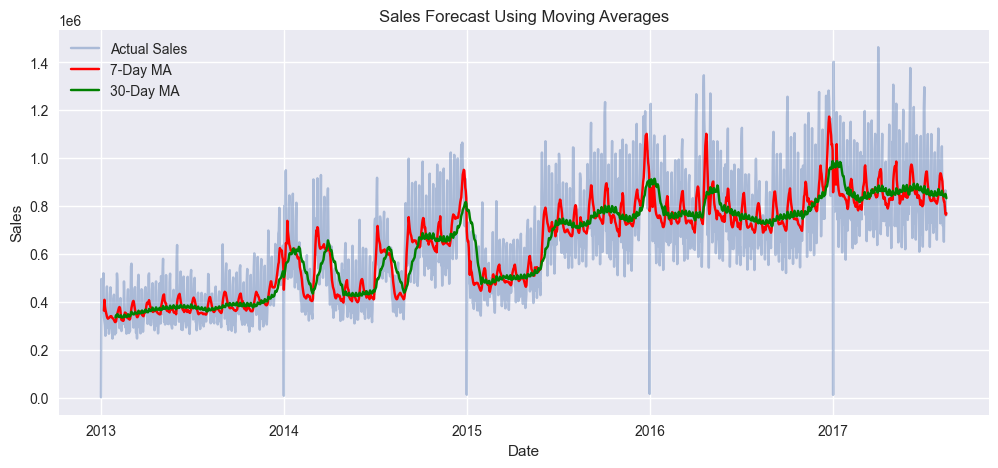

In [14]:
plt.figure(figsize=(12,5))
plt.plot(daily_sales['date'], daily_sales['sales'], label='Actual Sales', alpha=0.4)
plt.plot(daily_sales['date'], daily_sales['MA_7'], label='7-Day MA', color='red')
plt.plot(daily_sales['date'], daily_sales['MA_30'], label='30-Day MA', color='green')

plt.legend()
plt.title("Sales Forecast Using Moving Averages")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

In [15]:
comparison = daily_sales[['date', 'sales', 'MA_7', 'MA_30']].tail(15)
comparison

,date,sales,MA_7,MA_30
1669,2017-08-01,9.885278e+05,895150.071599,849869.872987
1670,2017-08-02,9.647120e+05,927158.496154,851188.826562
1671,2017-08-03,7.280685e+05,936904.018736,847712.466532
1672,2017-08-04,8.277757e+05,935857.733582,847161.602299
1673,2017-08-05,9.656937e+05,926340.988547,856008.990317
1674,2017-08-06,1.049559e+06,915741.943736,864134.552387
1675,2017-08-07,7.974650e+05,903114.532729,857438.478080
1676,2017-08-08,7.177663e+05,864434.330715,844669.578971
1677,2017-08-09,7.341397e+05,831495.424709,842335.606070
1678,2017-08-10,6.513869e+05,820540.914257,839697.344213


# _**TASK 3: Simple Sales Forecast with Moving Average**_

In [16]:
daily_sales['day'] = daily_sales['date'].dt.day
daily_sales['month'] = daily_sales['date'].dt.month
daily_sales['year'] = daily_sales['date'].dt.year

In [18]:
holidays = pd.read_csv("D:/sql datasets/store-sales-time-series-forecasting/holidays_events.csv")
holidays['date'] = pd.to_datetime(holidays['date'])

daily_sales = daily_sales.merge(
    holidays[['date', 'type']],
    on='date',
    how='left'
)

daily_sales['is_holiday'] = daily_sales['type'].notnull().astype(int)
daily_sales.drop(columns=['type'], inplace=True)


In [19]:
X = daily_sales[['day', 'month', 'year', 'is_holiday']]
y = daily_sales['sales']


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [21]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [22]:
y_pred = model.predict(X_test)


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MAE: 163581.47992175413
MSE: 36195288361.27971
R2 Score: -0.043620424328371765


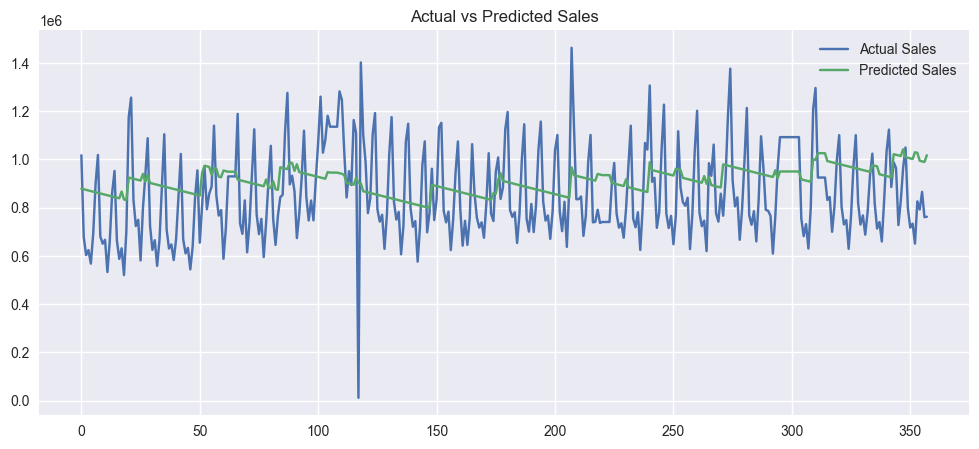

In [24]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label='Actual Sales')
plt.plot(y_pred, label='Predicted Sales')
plt.legend()
plt.title("Actual vs Predicted Sales")
plt.show()
